Credit to Msanjayds

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['gender_submission.csv', 'train.csv', 'test.csv']


**Titanic Survival Challenge**

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install fastai==0.7.0

    100% |████████████████████████████████| 122kB 11.1MB/s 
    100% |████████████████████████████████| 496.4MB 43kB/s 
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2
  Found existing installation: fastai 1.0.51
    Uninstalling fastai-1.0.51:
      Successfully uninstalled fastai-1.0.51


In [4]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import pylab as plot
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [10, 6]
}
plot.rcParams.update(params)

**Load train & test data**

In [5]:
train_raw = pd.read_csv('../input/train.csv', low_memory = False)
test_raw = pd.read_csv('../input/test.csv', low_memory = False)

Explore the data

In [6]:
train_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The count variable shows that 177 values are missing in the Age column.
Fill in the null values with the median age.

Visualize the survival based on the gender.

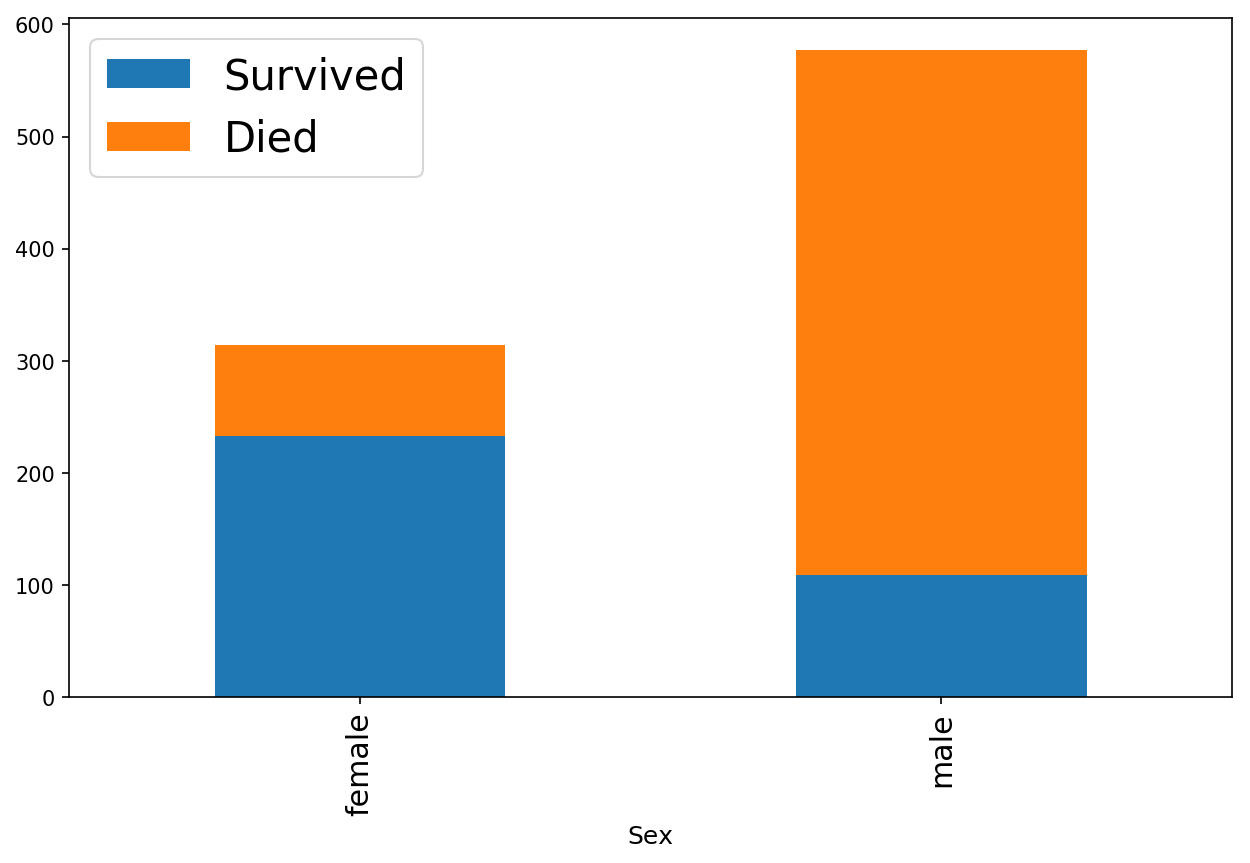

In [7]:
data = train_raw
data['Died'] = 1 - data['Survived']
data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar',stacked=True)

From the above graph, male passengers died more than that of female passengers.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


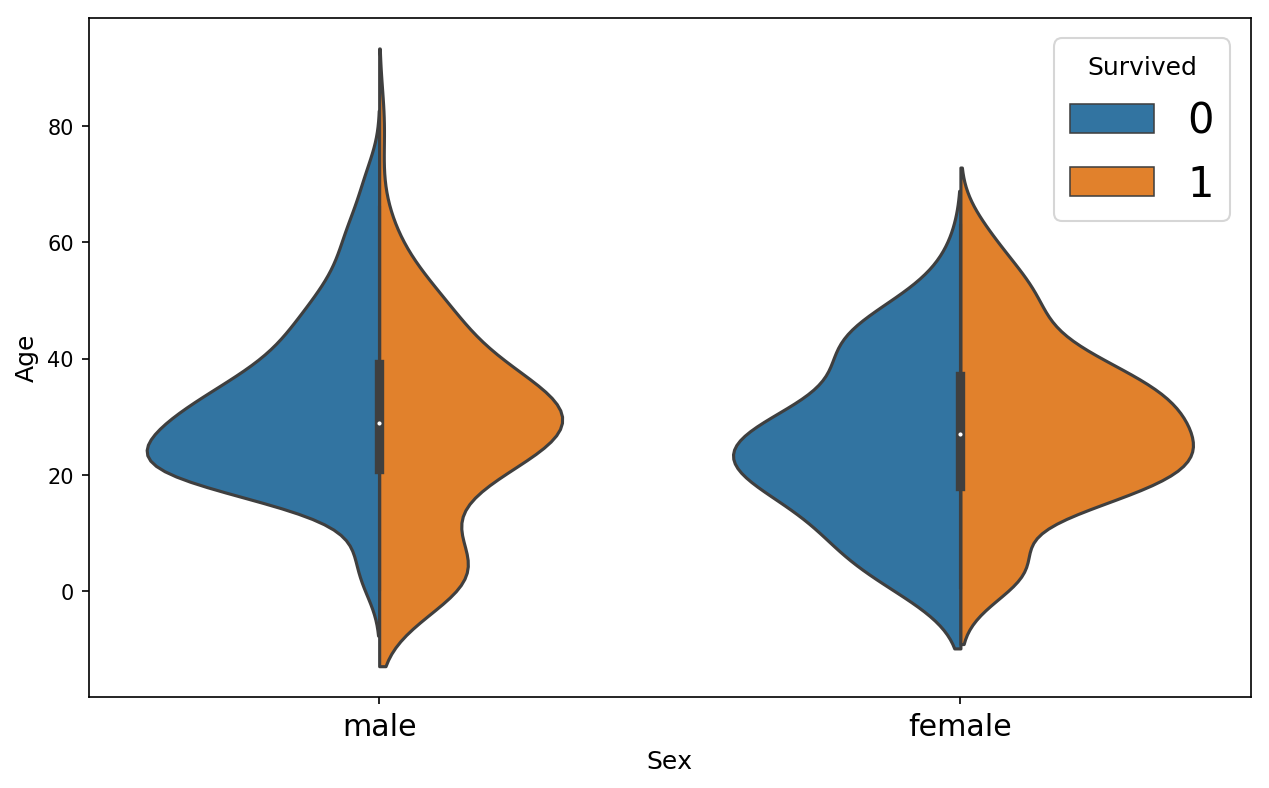

In [8]:
sns.violinplot(x='Sex', y='Age', hue='Survived', data=data, split=True)

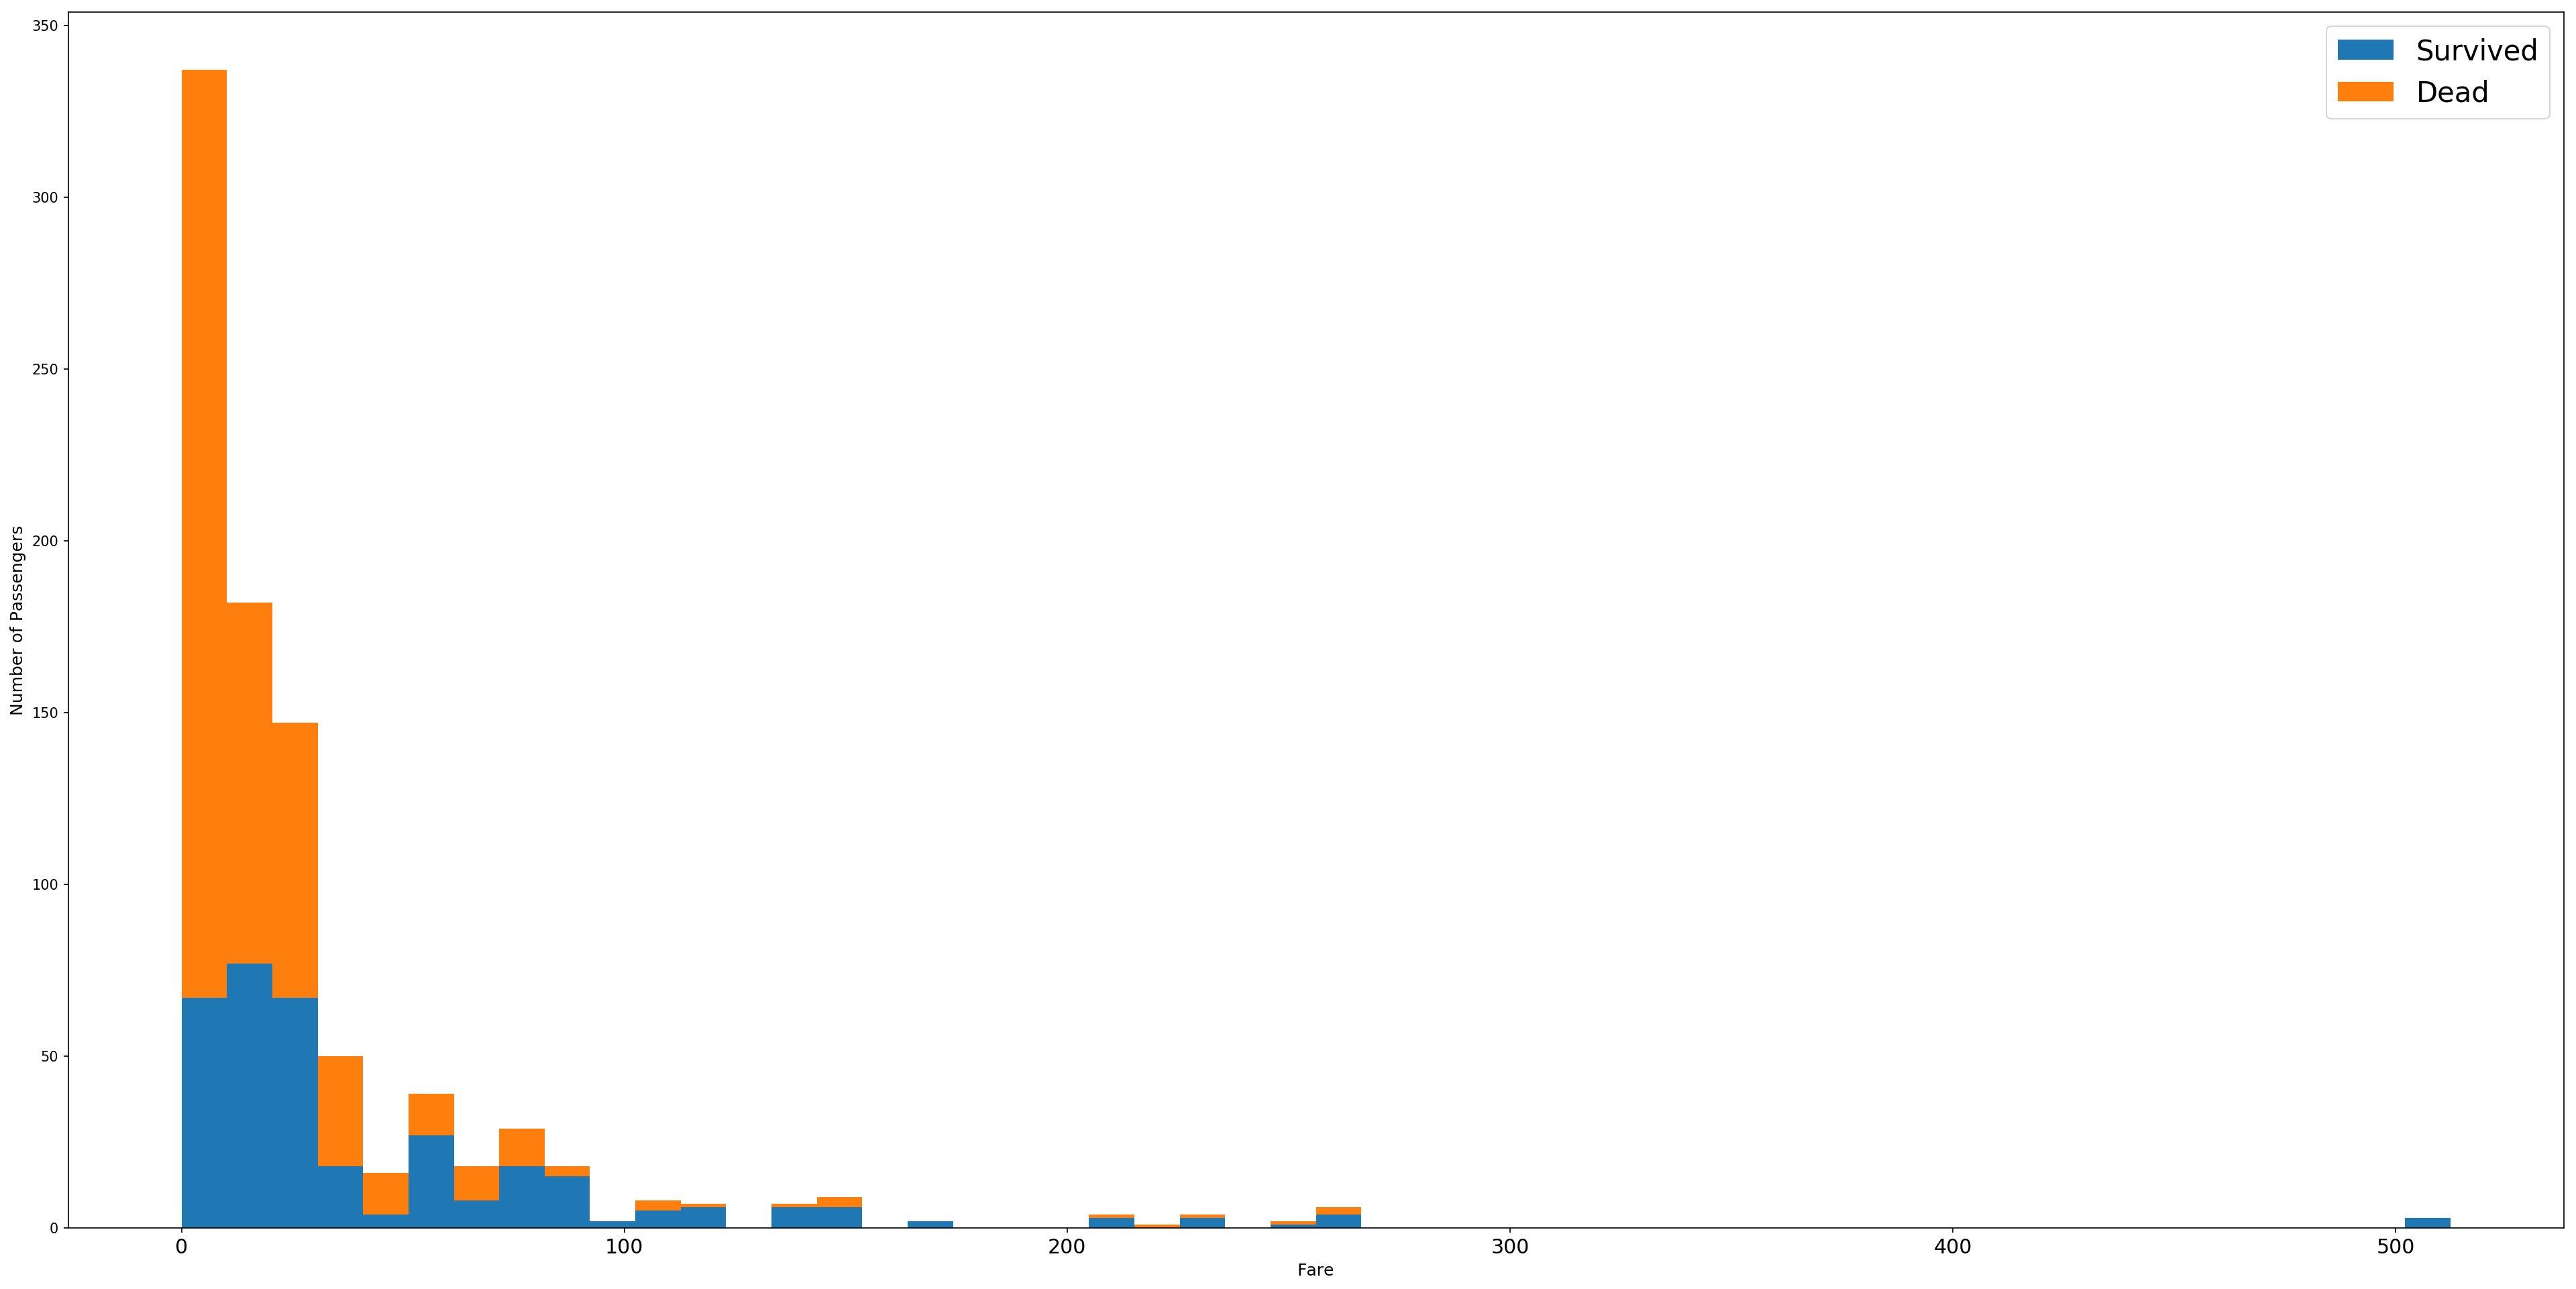

In [9]:
# Check the fare ticket of each passenger and how it impacts the survival.

figure = plt.figure(figsize=(32,16))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']],
         stacked = True,
         bins = 50, label = ['Survived', 'Dead']
        )
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.legend();

Passengers with lower ticket fare has less survival chance.

Text(0, 0.5, 'Fare')

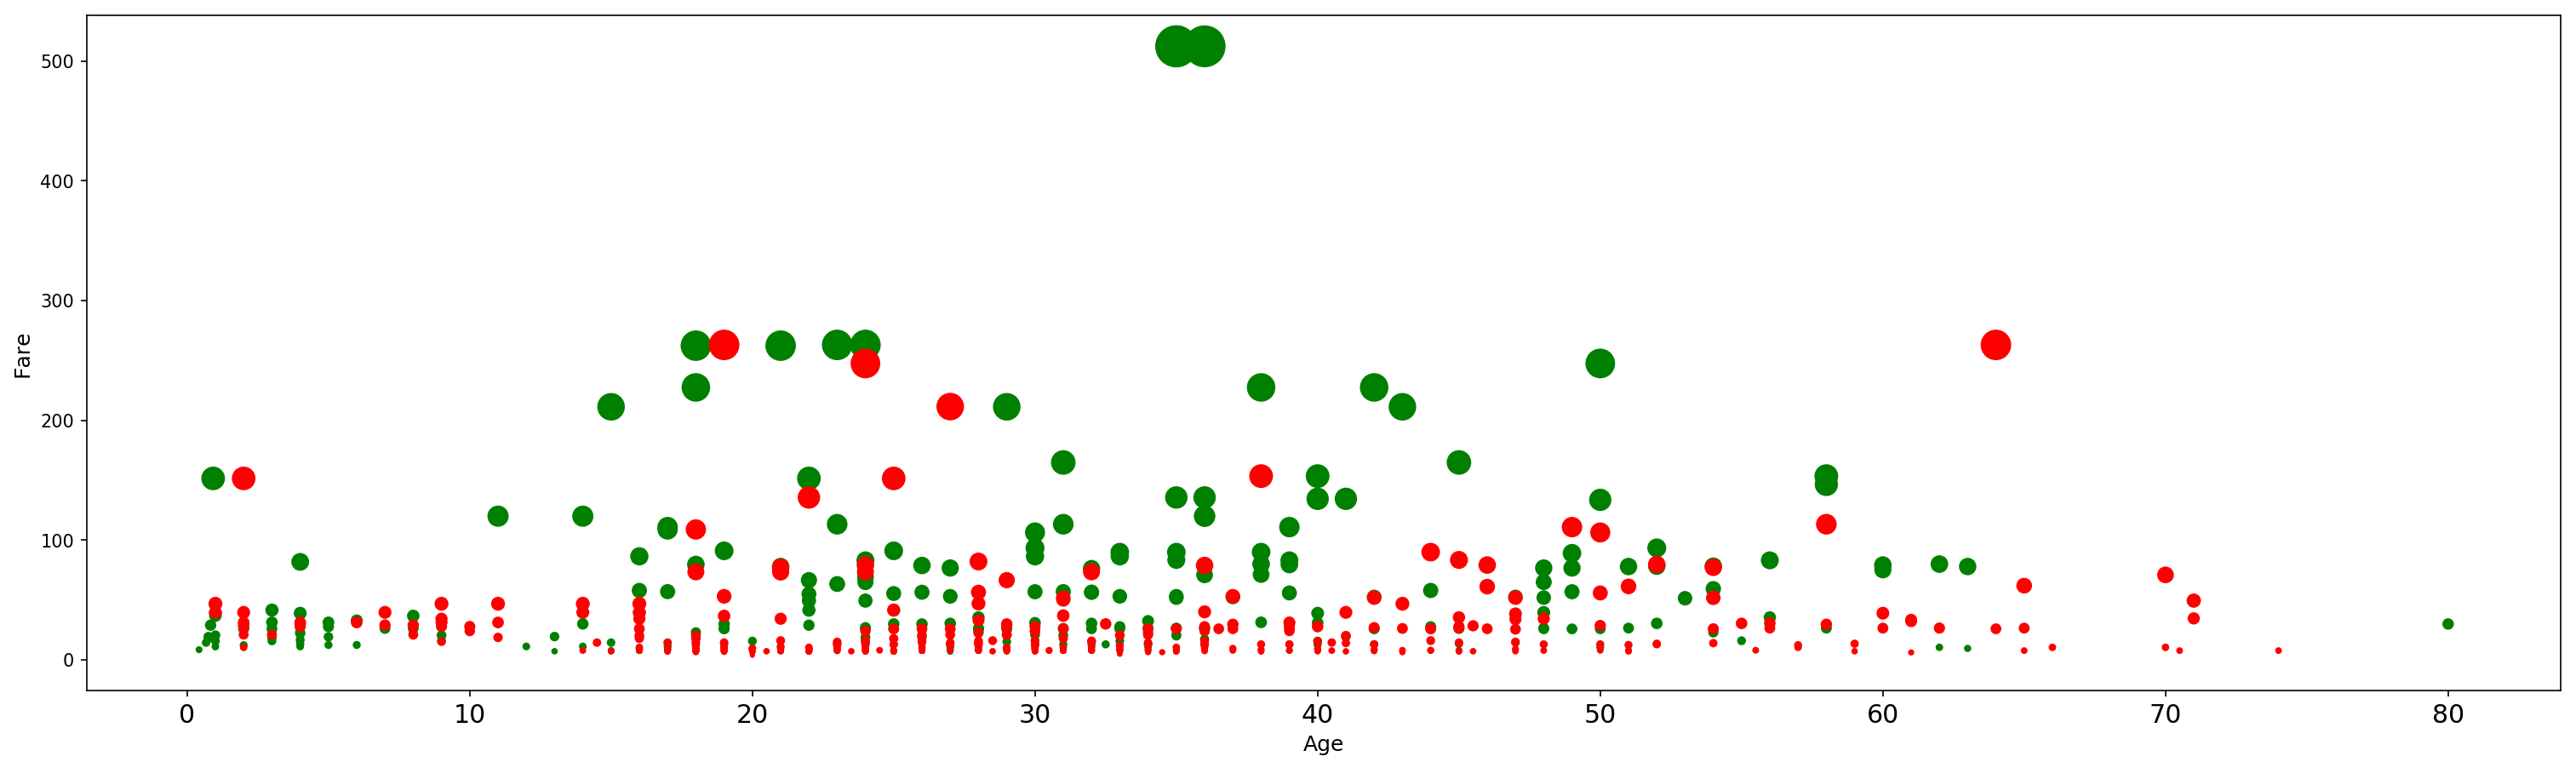

In [10]:
# Combining age, fare and survival in one chart.

plt.figure(figsize = (25,7))
ax = plt.subplot()

ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'], c = 'green', s = data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'], c = 'red', s = data[data['Survived'] == 0]['Fare']);

plt.xlabel('Age')
plt.ylabel('Fare')

Size of the circles is proportional to the ticket fare. Green = Survived; Red = Dead.

Small green dots between x = 0-7: Children who were saved.
Small red dots between x = 10-45: Adults who died and from a lower classes.
Large green dots between x = 20-45: Adults with higher ticket fare survived.

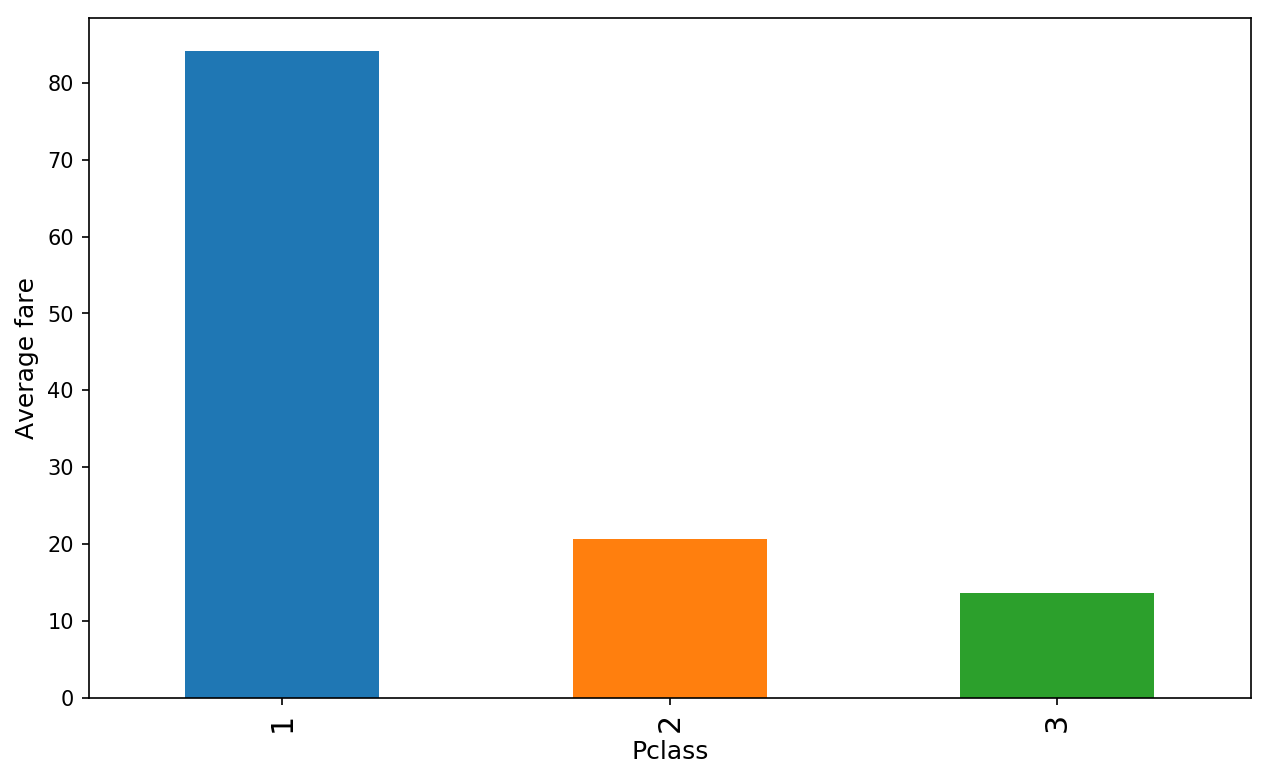

In [11]:
# ticket fare versus class

ax = plt.subplot()
ax.set_ylabel('Average fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar', ax=ax)

**Feature Engineering**

In [12]:
#Combining the test and train data to prepare the data for modelling.

x_train = train_raw.drop(['Survived','Died'], 1)
y_train = train_raw['Survived']
x_test = test_raw

In [13]:
df_combined = x_train.append(x_test, sort=False)
df_combined.shape

(1309, 11)

In [14]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [15]:
display_all(df_combined.tail())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [16]:
train_cats(df_combined)

In [17]:
# Check the missing data%
display_all(df_combined.isnull().sum().sort_index()/len(df_combined))

Age            0.200917
Cabin          0.774637
Embarked       0.001528
Fare           0.000764
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Ticket         0.000000
dtype: float64

In [18]:
# proc_df takes a dataframe df and splits off the response variable, and
# changes the df into an entirely numeric dataframe.
# Exclude the fields in ignore_flds as they need further processing.

df, y, nas = proc_df(df_combined, y_fld=None, ignore_flds = ['Age', 'Name', 'Embarked', 'Cabin', 'Parch', 'SibSp'])

df.head()

,Age,Name,Embarked,Cabin,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na
0,22.0,"Braund, Mr. Owen Harris",S,NaN,0,1,1,3,2,721,7.2500,False
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C,C85,0,1,2,1,1,817,71.2833,False
2,26.0,"Heikkinen, Miss. Laina",S,NaN,0,0,3,3,1,915,7.9250,False
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",S,C123,0,1,4,1,1,66,53.1000,False
4,35.0,"Allen, Mr. William Henry",S,NaN,0,0,5,3,2,650,8.0500,False


**Process Family**

In [19]:
def process_family():
    global df
    # introducing a new feature: the size of families (including the passenger)
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    
    # introducing other features based on the family size
    df['Singleton'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallFamly'] = df['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df['LargeFamly'] = df['FamilySize'].map(lambda s: 1 if 5 <= s  else 0)
    return df

In [20]:
df = process_family()

**Process Embarked**

In [21]:
def process_embarked():
    global df
    # two missing embarked values - filling them with the most frequent one in the train set(S)
    df.Embarked.fillna('S', inplace = True)
    # dummy encoding
    df_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, df_dummies], axis = 1)
    df.drop('Embarked', axis=1, inplace=True)
#     status('embarked')
    return df

In [22]:
df = process_embarked()

In [23]:
def process_cabin():
    global df
    # replacing missing cabins with T (for Unknown)
    df.Cabin.fillna('T', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    df['Cabin'] = df['Cabin'].map(lambda c: c[0])
    
    # dummy encoding
    cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')
    df = pd.concat([df, cabin_dummies], axis = 1)
    
    df.drop('Cabin', axis=1, inplace=True)
    return df

In [24]:
df = process_cabin()

In [25]:
df.head()

,Age,Name,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,FamilySize,Singleton,SmallFamly,LargeFamly,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,22.0,"Braund, Mr. Owen Harris",0,1,1,3,2,721,7.2500,False,2,0,1,0,0,0,1,0,0,0,0,0,0,0,1
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,2,1,1,817,71.2833,False,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0
2,26.0,"Heikkinen, Miss. Laina",0,0,3,3,1,915,7.9250,False,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,4,1,1,66,53.1000,False,2,0,1,0,0,0,1,0,0,1,0,0,0,0,0
4,35.0,"Allen, Mr. William Henry",0,0,5,3,2,650,8.0500,False,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1


**Get Title from Name**

In [26]:
titles = set()
for name in df['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

In [27]:
Title_Dictionary = {
    'Capt' : 'Officer',
    'Col' : 'Officer',
    'Major' : 'Officer',
    'Jonkheer' : 'Royalty',
    'Don' : 'Royalty',
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # extract the title from each name
    df['Title'] = df['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # map each title
    df['Title'] = df.Title.map(Title_Dictionary)
    return df

In [28]:
df = get_titles()
df.head()

,Age,Name,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,FamilySize,Singleton,SmallFamly,LargeFamly,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
0,22.0,"Braund, Mr. Owen Harris",0,1,1,3,2,721,7.2500,False,2,0,1,0,0,0,1,0,0,0,0,0,0,0,1,Mr
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,2,1,1,817,71.2833,False,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,Mrs
2,26.0,"Heikkinen, Miss. Laina",0,0,3,3,1,915,7.9250,False,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,Miss
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,4,1,1,66,53.1000,False,2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,Mrs
4,35.0,"Allen, Mr. William Henry",0,0,5,3,2,650,8.0500,False,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,Mr


**Process Age**

In [29]:
# Summarize the Age grouped by sex, class and title
grouped_train = df.groupby(['Sex', 'Pclass', 'Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

In [30]:
grouped_median_train

,Sex,Pclass,Title,Age
0,1,1,Miss,30.0
1,1,1,Mrs,45.0
2,1,1,Officer,49.0
3,1,1,Royalty,40.5
4,1,2,Miss,20.0
5,1,2,Mrs,30.0
6,1,3,Miss,18.0
7,1,3,Mrs,31.0
8,2,1,Master,6.0
9,2,1,Mr,41.5


In [31]:
# Estimating the missing values for age based on the group.
# If a title is missing, then age will be assigned based on sex and class.

def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) &
        (grouped_median_train['Title'] == row['Title']) &
        (grouped_median_train['Pclass'] == row['Pclass']) 
    )
    if np.isnan(grouped_median_train[condition]['Age'].values[0]):
        print('true')
        condition = (
            (grouped_median_train['Sex'] == row['Sex']) &
            (grouped_median_train['Pclass'] == row['Pclass'])
        )
    
    return grouped_median_train[condition]['Age'].values[0]

def process_age():
    global df
    # a function that fills the missing values of the Age variable
    df['Age'] = df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis = 1)
    return df

In [32]:
df = process_age()

In [33]:
# Check for missing values.

display_all(df.isnull().sum().sort_index()/len(df))

Age            0.000000
Cabin_A        0.000000
Cabin_B        0.000000
Cabin_C        0.000000
Cabin_D        0.000000
Cabin_E        0.000000
Cabin_F        0.000000
Cabin_G        0.000000
Cabin_T        0.000000
Embarked_C     0.000000
Embarked_Q     0.000000
Embarked_S     0.000000
FamilySize     0.000000
Fare           0.000000
Fare_na        0.000000
LargeFamly     0.000000
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Singleton      0.000000
SmallFamly     0.000000
Ticket         0.000000
Title          0.000764
dtype: float64

In [34]:
df[df.Title.isnull()]

,Age,Name,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,FamilySize,Singleton,SmallFamly,LargeFamly,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
414,39.0,"Oliva y Ocana, Dona. Fermina",0,0,1306,1,1,835,108.9,False,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,NaN


**Process Name**

In [35]:
def process_names():
    global df
    # Clean the Name variable
    df.drop('Name', axis = 1, inplace = True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(df['Title'], prefix = 'Title')
    df = pd.concat([df, titles_dummies], axis = 1)
    
    # removing the title variable
    df.drop('Title', axis = 1, inplace = True)
    
    return df

In [36]:
df = process_names()

In [37]:
df.head()

,Age,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,FamilySize,Singleton,SmallFamly,LargeFamly,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,22.0,0,1,1,3,2,721,7.2500,False,2,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,38.0,0,1,2,1,1,817,71.2833,False,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,26.0,0,0,3,3,1,915,7.9250,False,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,35.0,0,1,4,1,1,66,53.1000,False,2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,35.0,0,0,5,3,2,650,8.0500,False,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [38]:
# Now no null values
display_all(df.isnull().sum().sort_index()/len(df))

Age              0.0
Cabin_A          0.0
Cabin_B          0.0
Cabin_C          0.0
Cabin_D          0.0
Cabin_E          0.0
Cabin_F          0.0
Cabin_G          0.0
Cabin_T          0.0
Embarked_C       0.0
Embarked_Q       0.0
Embarked_S       0.0
FamilySize       0.0
Fare             0.0
Fare_na          0.0
LargeFamly       0.0
Parch            0.0
PassengerId      0.0
Pclass           0.0
Sex              0.0
SibSp            0.0
Singleton        0.0
SmallFamly       0.0
Ticket           0.0
Title_Master     0.0
Title_Miss       0.0
Title_Mr         0.0
Title_Mrs        0.0
Title_Officer    0.0
Title_Royalty    0.0
dtype: float64

**Build and train the model**

In [39]:
df.shape

(1309, 30)

In [40]:
# Separate out the train & test data
x_train = df[:891].copy()
x_test = df[891:].copy()
x_train.shape, x_test.shape

((891, 30), (418, 30))

In [41]:
# split the train data into train and valid set
def split_vals(a,n): return a[:n], a[n:]
valid_count = 60
n_trn = len(x_train) - valid_count
x_train1, x_valid1 = split_vals(x_train, n_trn)
y_train1, y_valid1 = split_vals(y_train, n_trn)

In [42]:
x_train1.shape, y_train1.shape, x_valid1.shape, y_valid1.shape

((831, 30), (831,), (60, 30), (60,))

In [43]:
m = RandomForestClassifier(n_estimators = 180, min_samples_leaf = 3, max_features = 0.5, n_jobs = -1)
m.fit(x_train1, y_train1)
m.score(x_train1, y_train1)

0.9350180505415162

**Model Evaluation**

In [44]:
y_predict = m.predict(x_valid1)
accuracy_score(y_valid1, y_predict)

0.9

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_valid1, y_predict))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        38
           1       0.90      0.82      0.86        22

   micro avg       0.90      0.90      0.90        60
   macro avg       0.90      0.88      0.89        60
weighted avg       0.90      0.90      0.90        60



In [46]:
# Confusion Matrix
print(confusion_matrix(y_valid1, y_predict))

[[36  2]
 [ 4 18]]


In [47]:
# Feature importance
fi = rf_feat_importance(m, x_train1); fi[:10]

,cols,imp
26,Title_Mr,0.179117
5,Sex,0.166738
6,Ticket,0.112568
7,Fare,0.093792
3,PassengerId,0.093399
0,Age,0.086729
4,Pclass,0.072512
9,FamilySize,0.030039
12,LargeFamly,0.023577
25,Title_Miss,0.022294


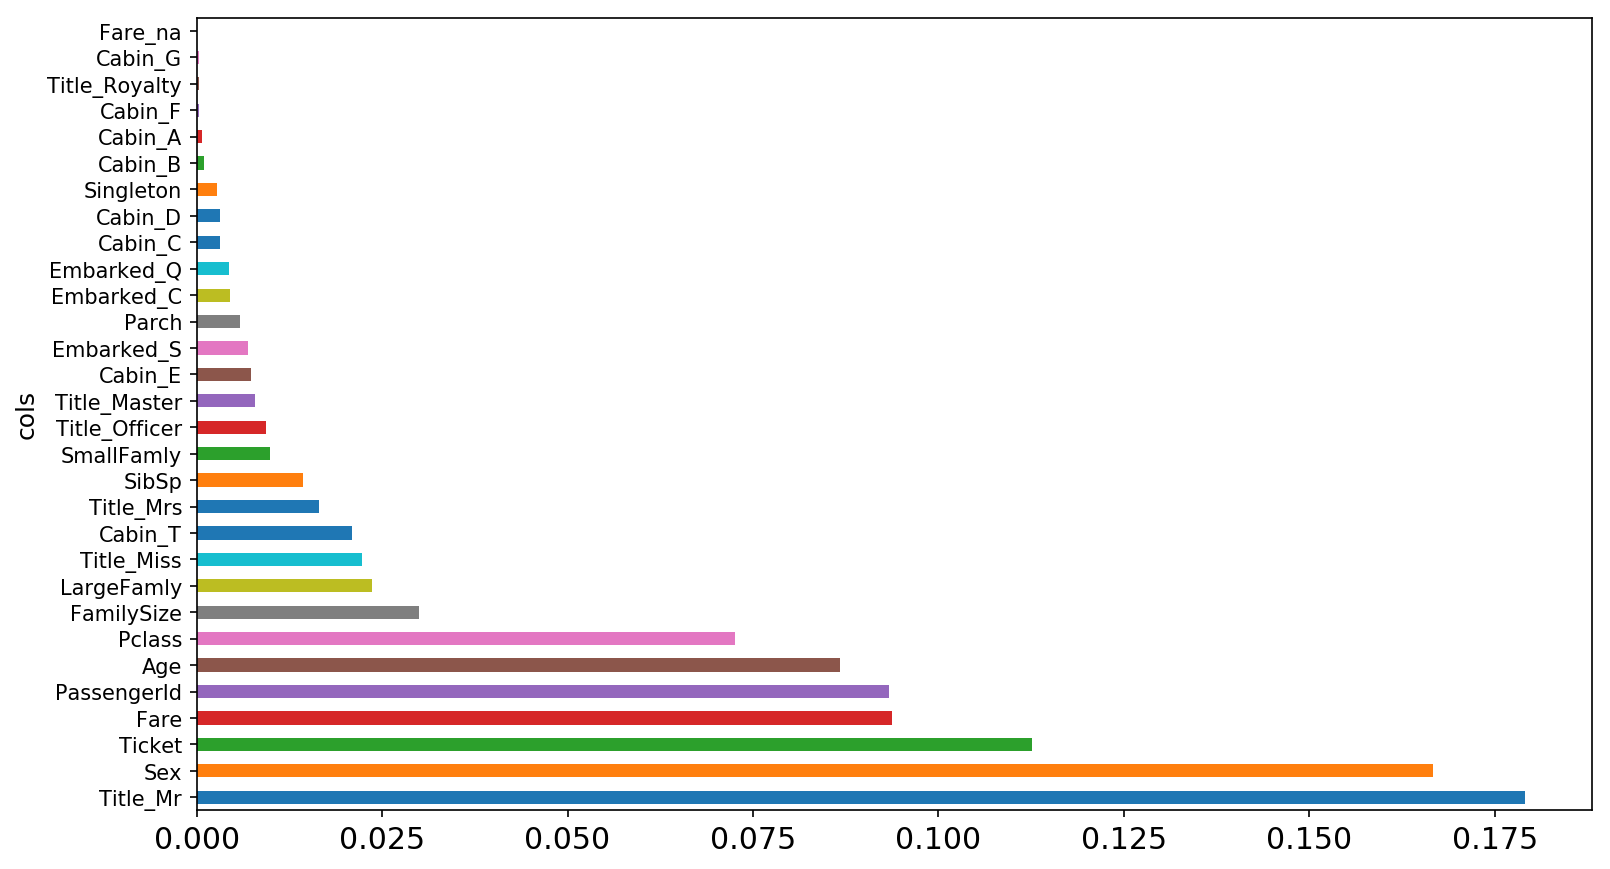

In [48]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [49]:
# Keeping only the variables which are significant for the model(>0.01)
to_keep = fi[fi.imp>0.01].cols; len(to_keep)
to_keep

26       Title_Mr
5             Sex
6          Ticket
7            Fare
3     PassengerId
0             Age
4          Pclass
9      FamilySize
12     LargeFamly
25     Title_Miss
23        Cabin_T
27      Title_Mrs
2           SibSp
Name: cols, dtype: object

**Final Model**

In [50]:
# Now training the model on the entire data with only the important features.
x_train = x_train[to_keep]
x_train

,Title_Mr,Sex,Ticket,Fare,PassengerId,Age,Pclass,FamilySize,LargeFamly,Title_Miss,Cabin_T,Title_Mrs,SibSp
0,1,2,721,7.2500,1,22.0,3,2,0,0,1,0,1
1,0,1,817,71.2833,2,38.0,1,2,0,0,0,1,1
2,0,1,915,7.9250,3,26.0,3,1,0,1,1,0,0
3,0,1,66,53.1000,4,35.0,1,2,0,0,0,1,1
4,1,2,650,8.0500,5,35.0,3,1,0,0,1,0,0
5,1,2,374,8.4583,6,26.0,3,1,0,0,1,0,0
6,1,2,110,51.8625,7,54.0,1,1,0,0,0,0,0
7,0,2,542,21.0750,8,2.0,3,5,1,0,1,0,3
8,0,1,478,11.1333,9,27.0,3,3,0,0,1,1,0
9,0,1,175,30.0708,10,14.0,2,2,0,0,1,1,1


In [51]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(x_train, y_train)
m.score(x_train, y_train)

0.9315375982042648

We could notice that the score has increased after removing some features and training on the complete data.

**Run the model on the test data**

In [52]:
x_test = x_test[to_keep]
output = m.predict(x_test).astype(int)

In [53]:
output.size

418

**Save the output predictions in the required format and submit to Kaagle**

In [54]:
aux = pd.read_csv('../input/test.csv', low_memory = False)
df_output = pd.DataFrame()
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId', 'Survived']].to_csv('Titanic_RandomForestClassifier.csv', index = False)